In [1]:
import unicodedata
import string
import re
import random

In [2]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Load Generated Data
- load base, complex, and nested expression pairs
- shuffle base and complex expression pairs
- split into train and test sets

In [3]:
# read all base expression pairs
base_expression = []

with open('./data/base_expression.txt', 'r') as f:
    lines = f.readlines()
    
for l in lines[1:]: # skip first line
    pair = l.split(';')
    base_expression.append([pair[0], pair[1][:-1]]) # exclude \n

In [4]:
# read all complicate expression pairs
complex_expression = []

with open('./data/complex_expression.txt', 'r') as f:
    lines = f.readlines()
    
for l in lines[1:]: # skip first line
    pair = l.split(';')
    complex_expression.append([pair[0], pair[1][:-1]])

In [5]:
# read all nested expression pairs
# these expressions would be for testing only
nested_expression = []

with open('./data/nested_expression.txt', 'r') as f:
    lines = f.readlines()
    
for l in lines[1:]:
    pair = l.split(';')
    nested_expression.append([pair[0], pair[1][:-1]])

In [6]:
# shuffle
random.shuffle(base_expression)
random.shuffle(complex_expression)


# train-test split
train_ratio = 0.8
n_base = len(base_expression)
n_comp = len(complex_expression)

train_expression = base_expression[:int(0.8*n_base)] + complex_expression[:int(0.8*n_comp)]
test_expression = base_expression[int(0.8*n_base):] + complex_expression[int(0.8*n_comp):]
random.shuffle(train_expression)

## Processing
 - convert expressions into vector representation via tokenizer for latex/natural expressions respectively
 - convert vector representation into proper tensors
 - collect token/word counts
 - generate token/word cloud plot

In [7]:
# define tokenizer for latex expression

# read defined latex tokens
with open('./data/latex_token.txt', 'r') as f:
    latex_token = f.readline().split(';')

# drop the last null token
latex_token = latex_token[:-1]
    
    
class latex_tokenizer:
    SOS = 0 # start of string
    EOS = 1 # end of string
    
    def __init__(self):
        self.n_token = 2
        self.token2index = {'SOS': self.SOS, 'EOS': self.EOS}
        self.index2token = {self.SOS: 'SOS', self.EOS: 'EOS'}
        self.token_count = {} # not counting SOS/EOS
        
        # initialize the two dictionaries
        for token in latex_token:
            self.token2index[token] = self.n_token
            self.index2token[self.n_token] = token
            self.token_count[token] = 0
            self.n_token += 1
            
    
    
    # convert input expression to index representation using the tokenizer
    def tokenize(self, expression):
        '''
        expression: must be a string
        '''
        
        result = [self.token2index['SOS']]
        buffer = ''
        
        for c in expression:
            
            if buffer not in self.token2index:
                buffer += c
            
            # updated buffer: need to check it again
            if buffer in self.token2index:
                result.append(self.token2index[buffer])
                self.token_count[buffer] += 1
                buffer = ''
        
        # if buffer is non-empty, there is error
        if buffer != '':
            return -1
        
        result.append(self.token2index['EOS'])
        return result
    
    
    
    # convert input tokens back to latex expression
    # ignore SOS/EOS
    def detokenize(self, indices):
        '''
        indices: list of indices
        '''
        string = ''
        
        for i in indices:
            token = self.index2token[i]
            if token != 'SOS' and token != 'EOS':
                string = string + token
        
        return string  

In [8]:
# token for natural expression would just be word
class natural_vectorizer:
    SOS = 0 # start of string
    EOS = 1 # end of string
    
    def __init__(self):
        self.n_word = 2
        self.word2index = {'SOS': self.SOS, 'EOS': self.EOS}
        self.index2word = {self.SOS: 'SOS', self.EOS: 'EOS'}
        self.word_count = {} # not counting SOS/EOS
        
        
    
    def vectorize(self, expression):
        result = [self.word2index['SOS']]
        buffer = ''
        
        words = expression.split(' ')
        
        for w in words:
            if w not in self.word2index:
                # add new word
                self.word2index[w] = self.n_word
                self.index2word[self.n_word] = w
                self.word_count[w] = 1
                self.n_word += 1
                
                # append result
                result.append(self.word2index[w])
                
            else:
                self.word_count[w] += 1
                result.append(self.word2index[w])
        
        result.append(self.word2index['EOS'])
        return result
    
    def devectorize(self, vec):
        string = ''
        
        for v in vec:
            word = self.index2word[v]
            if word != 'SOS' and word != 'EOS':
                string = string + word
                
        return string

In [9]:
# convert train/test/nested expressions into index vector representations (each is a torch.tensor)
lt = latex_tokenizer()
nv = natural_vectorizer()

def expression2vec(expression):
    vec = []
    
    for pair in expression:
        v_pair = []
        v_pair.append(torch.tensor(lt.tokenize(pair[0])).reshape(-1,1))
        v_pair.append(torch.tensor(nv.vectorize(pair[1])).reshape(-1,1))

        vec.append(v_pair)
    
    return vec

train_vec = expression2vec(train_expression)
test_vec = expression2vec(test_expression)
nested_vec = expression2vec(nested_expression)

In [10]:
# check if there is anything wrong

MAX_LENGTH = 0

for i in range(len(train_vec)):
    if sum(train_vec[i][0]) == -1:
        print('latex tokenize fails, original expression', train_expression[i][0])
    
    if len(train_vec[i][0]) > MAX_LENGTH:
        MAX_LENGTH = len(train_vec[i][0])
    
    if len(train_vec[i][1]) > MAX_LENGTH:
        MAX_LENGTH = len(train_vec[i][1])
    
    
    
for i in range(len(test_vec)):
    if sum(test_vec[i][0]) == -1:
        print('latex tokenize fails, original expression', test_expression[i][0])
        
    if len(test_vec[i][0]) > MAX_LENGTH:
        MAX_LENGTH = len(test_vec[i][0])
    
    if len(test_vec[i][1]) > MAX_LENGTH:
        MAX_LENGTH = len(test_vec[i][1])

In [206]:
print(MAX_LENGTH)

22


(-0.5, 399.5, 199.5, -0.5)

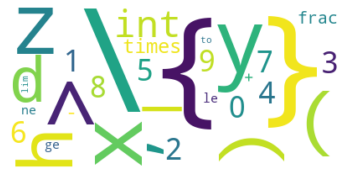

In [12]:
# token/word cloud plot
wc = WordCloud(background_color="white", max_words=1000)
wc.generate_from_frequencies(lt.token_count)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

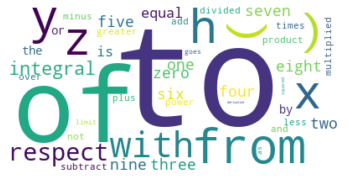

In [13]:
wc = WordCloud(background_color="white", max_words=1000)
wc.generate_from_frequencies(nv.word_count)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

## Encoder Decoder
- modified from https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [20]:
from network import *

In [31]:
teacher_forcing_ratio = 0.5

SOS_token = 0
EOS_token = 1

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [84]:
def test(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    with torch.no_grad():

        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        loss = 0

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(
                input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)

        decoder_hidden = encoder_hidden

        
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    return loss.item() / target_length

In [91]:
def trainIters(encoder, decoder, n_iters, batch_size=100, learning_rate=0.01):
    start = time.time()
    train_loss = [] # per batch
    test_loss = []
    train_loss_batch = 0  # Reset every batch

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [random.choice(train_vec) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        train_loss_batch += loss

        if iter % batch_size == 0:
            train_loss.append(train_loss_batch/batch_size)
            train_loss_batch = 0
            
            # compute test loss
            testing_pairs = [random.choice(test_vec) for i in range(batch_size)]
            loss = 0
            for p in testing_pairs:
                loss += test(p[0], p[1], encoder,
                             decoder, criterion)
            test_loss.append(loss/batch_size)
            

    return train_loss, test_loss

In [46]:

import matplotlib.ticker as ticker
import numpy as np

In [67]:
def evaluate(encoder, decoder, expression, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = torch.tensor(lt.tokenize(expression)).reshape(-1,1)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(nv.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [65]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(test_expression)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [92]:
hidden_size = 64
encoder1 = Encoder(lt.n_token, hidden_size).to(device)
attn_decoder1 = AttnDecoder(hidden_size, nv.n_word, dropout_p=0.1).to(device)

loss = trainIters(encoder1, attn_decoder1, 20000)

Text(0.5, 1.0, 'Average loss versus training interation')

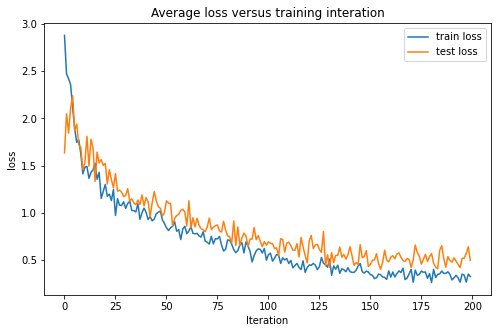

In [94]:
# plot loss versus n batch
plt.figure(figsize=(8,5))
plt.plot(loss[0])
plt.plot(loss[1])
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.legend(['train loss', 'test loss'])
plt.title('Average loss versus training interation')

In [211]:
evaluateRandomly(encoder1, attn_decoder1)

> 5^0
= five to the power of zero
< SOS five to the power of zero <EOS>

> 5 \ge 9
= five is greater or equal to nine
< SOS five is greater or equal to nine <EOS>

> 3 \times 7
= three multiplied by seven
< SOS product of seven and seven <EOS>

> z^z
= z to the power of z
< SOS z to the z <EOS>

> \int_{3}^{4} h(y) \,dx
= integral of h ( y ) from three to four with respect to x
< SOS integral of h ( y ) from three to four with respect to x <EOS>

> 6+9
= add six to nine
< SOS add six to nine <EOS>

> \int_{9}^{3} h(x) \,dx
= integral of h ( x ) from nine to three with respect to x
< SOS integral of h ( x ) from nine to three with respect to x <EOS>

> \int_{1}^{2} h(y) \,dz
= integral of h ( y ) from one to two with respect to z
< SOS integral of h ( y ) from one to two with respect to z <EOS>

> \int_{9}^{5} h(y) \,dy
= integral of h ( y ) from nine to five with respect to y
< SOS integral of h ( y ) from nine to five with respect to y <EOS>

> \int_{3}^{9} h(z) \,dz
= integral of h (

In [95]:
evaluateRandomly(encoder1, attn_decoder1)

> y \le 6
= y is less or equal to six
< SOS y is less or equal to six <EOS>

> 1 \times 2
= one times two
< SOS one times two <EOS>

> 0 \times 6
= zero multiplied by six
< SOS zero times six <EOS>

> 3+y
= add three to y
< SOS add plus to y <EOS>

> 0 \times 7
= zero times seven
< SOS product of seven and seven <EOS>

> \int_{9}^{5} h(y) \,dy
= integral of h ( y ) from nine to five with respect to y
< SOS integral of h ( y ) from nine to five with respect to y <EOS>

> y-2
= y minus two
< SOS subtract two from <EOS>

> 9^6
= nine to the six
< SOS nine to the power of six <EOS>

> \frac{3}{3}
= three over three
< SOS three divided three <EOS>

> 6-7
= six minus seven
< SOS subtract seven from six <EOS>



input = \int_{3}^{9} h(x) \,dx
output = SOS integral of h ( x ) from three to nine with respect to x <EOS>


/var/folders/cf/nlvxpf6564s_1x5tcqcdgcjr0000gn/T/ipykernel_43152/2485757939.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['SOS']  + xticks[:-1] + ['EOS'], rotation=90)
/var/folders/cf/nlvxpf6564s_1x5tcqcdgcjr0000gn/T/ipykernel_43152/2485757939.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['SOS'] + output_words[:-1] + ['EOS'])


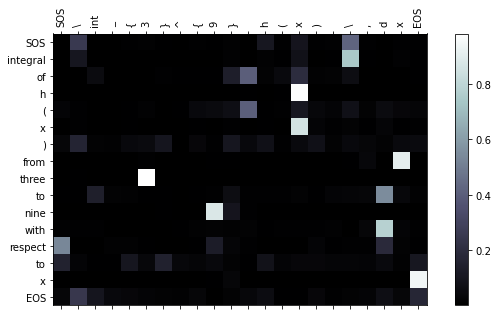

In [210]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize = (10, 5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    xticks = [lt.index2token[test_vec[-1][0][i].item()] for i in range(22)]
    
    
    ax.set_xticklabels(['SOS']  + xticks[:-1] + ['EOS'], rotation=90)
    ax.set_yticklabels(['SOS'] + output_words[:-1] + ['EOS'])

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention(test_expression[-1][0])

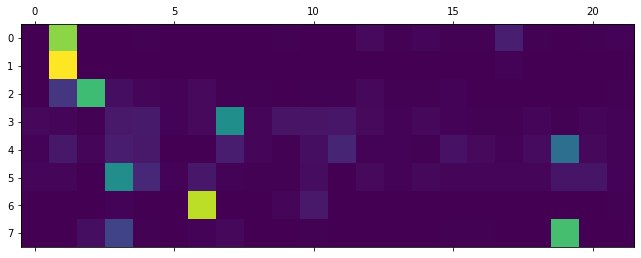

In [213]:
# evaluate on nested expression
output_word1, attention1 = evaluate(encoder1, attn_decoder1, nested_expression[0][0])
plt.matshow(attention1.numpy())

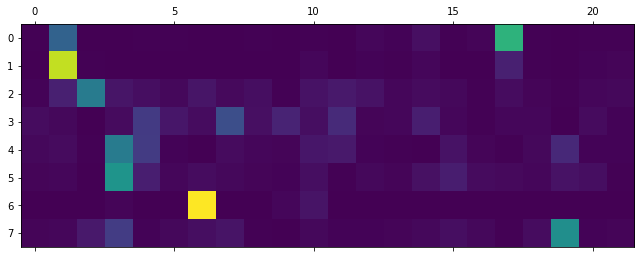

In [214]:
# evaluate on nested expression 2
output_word2, attention2 = evaluate(encoder1, attn_decoder1, nested_expression[1][0])
plt.matshow(attention2.numpy())

In [215]:
output_word1

['SOS', 'x', 'is', 'not', 'equal', 'to', 'two', '<EOS>']

In [216]:
output_word2

['SOS', 'x', 'is', 'not', 'equal', 'to', 'one', '<EOS>']

In [218]:
nested_expression[0][1], nested_expression[1][1]

('x to the two is less or equal to x plus five',
 'x plus one over x is not equal to one')